In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import time
import scipy
import pickle


from multiprocess import Pool
from multiprocess import Process


warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

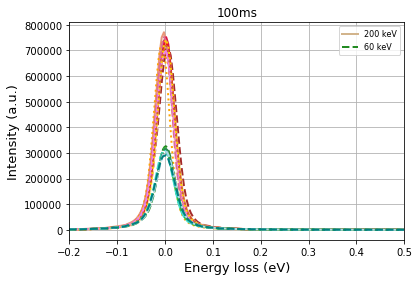

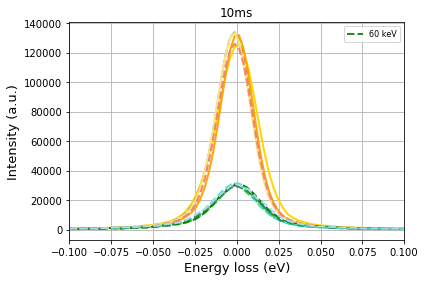

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y7,y8,y9,y10,y11,y12,y13,y14,time,energy
0,-0.954367,-0.944701,-0.937729,-0.958633,-0.948669,-0.849981,-0.849981,-0.923697,-0.923995,-0.923974,...,92.20340,105.04800,13.45050,12.18790,155.20100,85.3088,63.73150,112.94600,100,200
1,-0.949700,-0.940104,-0.933188,-0.953899,-0.944007,-0.845943,-0.845943,-0.919090,-0.919584,-0.919522,...,78.92470,74.33620,25.23600,49.73030,50.40090,56.2916,2.69122,9.44138,100,200
2,-0.945034,-0.935507,-0.928647,-0.949165,-0.939345,-0.841906,-0.841906,-0.914483,-0.915173,-0.915070,...,2.07308,-61.09940,43.59180,7.21912,64.60960,-13.0748,-26.52960,-4.13263,100,200
3,-0.940368,-0.930910,-0.924106,-0.944431,-0.934683,-0.837868,-0.837868,-0.909876,-0.910763,-0.910618,...,-81.36660,19.94870,3.99171,-96.36250,19.54320,63.6954,-49.04250,100.48400,100,200
4,-0.935701,-0.926313,-0.919565,-0.939697,-0.930021,-0.833830,-0.833830,-0.905269,-0.906352,-0.906166,...,-29.48940,44.42410,11.74030,25.47450,-2.63605,21.0576,57.26170,80.27130,100,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,8.579001,8.447313,8.339865,8.712997,8.575721,7.399130,7.399130,8.488369,8.087052,8.171466,...,-57.73360,-30.63200,-63.48630,-94.41850,19.38750,-87.4528,-59.78820,-89.61530,100,200
2044,8.583668,8.451910,8.344406,8.717731,8.580383,7.403168,7.403168,8.492976,8.091463,8.175918,...,-43.72820,-42.44820,2.59805,-44.51020,7.85684,73.2205,-27.22800,69.37240,100,200
2045,8.588334,8.456507,8.348947,8.722465,8.585045,7.407206,7.407206,8.497583,8.095873,8.180370,...,-47.30900,-69.28850,-138.34900,-37.34680,-22.39200,-33.2063,-32.43110,18.32600,100,200
2046,8.593000,8.461104,8.353488,8.727199,8.589707,7.411243,7.411243,8.502190,8.100284,8.184822,...,-96.15140,41.74130,-70.35200,-64.79110,-26.25640,-113.8630,-73.95380,16.47460,100,200


In [143]:
%run EELS-ZLP-Mar.py

file100_200


In [134]:
file = file10_200
fwhm_array = []

for i in range(0,11):
    x = file['x%(i)s'%{"i": i}]
    y = file['y%(i)s'%{"i": i}]
    
    fwhm = x[(x>0) & (y < (y.max()/2))].min()
    fwhm_array.append(fwhm)
print(np.mean(fwhm_array)*5000)
print(np.std(fwhm_array)*5000)

8.965549538352269
4.741225942249778


In [130]:
## Drop all data between FWHM and end

,x,y,sigma,time,energy
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.500000,0.146038,0.012053,0.550000,1.300000
std,0.587165,0.145834,0.027735,0.450433,0.700674
min,-0.100000,0.098390,0.000700,0.100000,0.600000
25%,0.093939,0.100000,0.000700,0.100000,0.600000
50%,0.290909,0.100646,0.001787,0.550000,1.300000
75%,0.487879,0.107910,0.020000,1.000000,2.000000
max,2.000000,0.959574,0.351361,1.000000,2.000000


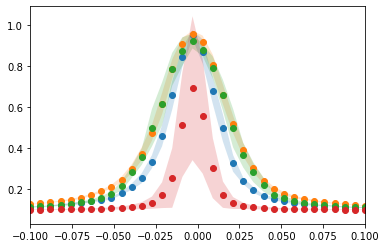

In [131]:
%run Functions.ipynb
meanfile = pd.DataFrame()
from copy import copy
mean = []
columns = ['x', 'y', 'time', 'energy']

file10_60 = pd.read_csv('Data/Vacuum/Datafiles/10_60_total.csv', skiprows = 1, names=columns)
file100_60 = pd.read_csv('Data/Vacuum/Datafiles/100_60_total.csv', skiprows = 1, names=columns)
file10_200_1 = pd.read_csv('Data/Vacuum/Datafiles/10_200_total.csv', skiprows = 1, names=columns)
file100_200= pd.read_csv('Data/Vacuum/Datafiles/100_200_total.csv', skiprows = 1, names=columns)

file10_200 = file10_200_1.copy()
file10_200['x'] = file10_200_1['x'] * 4

for i, file in enumerate([file10_60, file100_60, file100_200, file10_200]):
    E_min = -.1
    E_max = 0.5
   
    window_file = file[(file['x'] > E_min) & (file['x'] < E_max)]
    window_file['y_norm'] = np.divide(window_file['y'], window_file['y'].max())
    window_file['y_scaled'] = (window_file['y_norm'])*((8/9))+.1
    
    if i == 3:
        nbins = 100
        
    else:
        nbins = 100
        
        
    meanfile = pd.DataFrame()
    meanfile['x'] = np.linspace(E_min, E_max, nbins)
    meanfile['y'] = binned_statistics(window_file['x'], window_file['y_scaled'], nbins)[0]
    meanfile['sigma'] = binned_statistics(window_file['x'], window_file['y_scaled'], nbins)[1]


    meanfile['time'] = file['time'].max()/100
    meanfile['energy'] = file['energy'].max()/100
    
    meanfile['sigma'][meanfile['sigma'] < .0007] = .0007
    time=file['time']/100
    energy = file['energy']/100
    ## Create pseudo data 
    min_x = dE2 = 1
    max_x = 2
    N_pseudo = 30

    df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': .1 * np.ones(N_pseudo), \
                        'sigma': .02 * np.ones(N_pseudo), 'time': time.max(), 'energy': energy.max()})

    df_full = pd.concat([meanfile, df_pseudo])

    df_full.describe()
    ###########
    
    plt.plot(df_full['x'],df_full['y'], 'o')
    plt.fill_between(df_full['x'], df_full['y']+df_full['sigma'],df_full['y']-df_full['sigma'], alpha=.2)
    plt.xlim([-.1, .1])
    
    mean.append(df_full)
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

total_mean = pd.concat(mean, axis=0, ignore_index=True)


total_mean.describe()

### Create architecture

In [109]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [110]:
tf.compat.v1.get_default_graph
from copy import copy
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
%run Functions.ipynb

x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_full = total_mean
#df_full = df_full.drop_duplicates(subset=['y'])
df_full = df_full.sort_values(by='x')
predictions = make_model(x,1)

df_full.describe()

,x,y,sigma,time,energy
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.500000,0.146038,0.012053,0.550000,1.300000
std,0.587165,0.145834,0.027735,0.450433,0.700674
min,-0.100000,0.098390,0.000700,0.100000,0.600000
25%,0.093939,0.100000,0.000700,0.100000,0.600000
50%,0.290909,0.100646,0.001787,0.550000,1.300000
75%,0.487879,0.107910,0.020000,1.000000,2.000000
max,2.000000,0.959574,0.351361,1.000000,2.000000


In [111]:
df_train, df_test = train_test_split(df_full, test_size=0.2)

cols=[ 'x', 'time', 'energy', 'sigma']
train_inputs = df_train.drop(['y'], axis=1)[cols]
train_outputs = df_train['y']
test_inputs = df_test.drop(['y'], axis=1)[cols]
test_outputs = df_test['y']

train_x = train_inputs.drop('sigma', axis=1).to_numpy()
train_y = train_outputs.to_numpy()
train_sigma = train_inputs['sigma'].to_numpy()
test_x = test_inputs.drop('sigma', axis=1).to_numpy()
test_y = test_outputs.to_numpy()
test_sigma = test_inputs['sigma'].to_numpy()

df_test.describe()

train_sigma.shape


(416,)

## Create MC replicas

In [112]:
### Create array of Nrep training samples
Nrep = 5000
N_train = len(train_y)
N_test = len(test_y)

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)



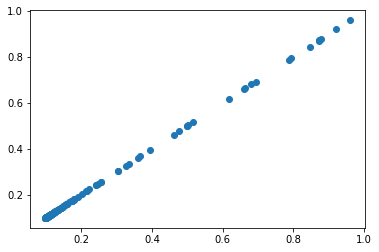

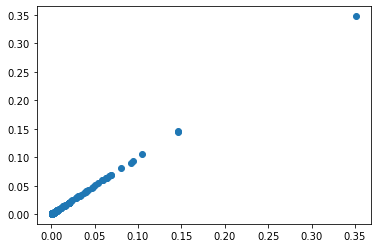

In [113]:
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')

In [114]:
## Beam energy interpolation

import random

part1 = 1000
N_pred = 10 * part1

interpol_energy1 = .2 #*100 keV
interpol_energy2 = .4 #*100 keV
interpol_energy3 = .6
interpol_energy4 = .8
interpol_energy5 = 1.2
interpol_energy6 = 1.8
interpol_energy7 = 2
interpol_energy8 = 2.2
interpol_energy9 = 2.5
interpol_energy10 = 3

interpol_time = .1
E_min = -.8
E_max = -.1

#Energy --> Energy range veranderen zodat het alleen interpolatie doet op E. 
predict_x = np.zeros(shape=(N_pred, 3))
predict_x[0*part1:1*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[1*part1:2*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[3*part1:4*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[4*part1:5*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[5*part1:6*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[6*part1:7*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[7*part1:8*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[8*part1:9*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[9*part1:10*part1, 0] = np.linspace(E_min,E_max,part1)

#Time
predict_x[:,1] = interpol_time * np.ones(N_pred)

# E_beam
predict_x[0*part1:1*part1,2] = interpol_energy1 * np.ones(part1)
predict_x[1*part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:4*part1,2] = interpol_energy4 * np.ones(part1)
predict_x[4*part1:5*part1,2] = interpol_energy5 * np.ones(part1)
predict_x[5*part1:6*part1,2] = interpol_energy6 * np.ones(part1)
predict_x[6*part1:7*part1,2] = interpol_energy7 * np.ones(part1)
predict_x[7*part1:8*part1,2] = interpol_energy8 * np.ones(part1)
predict_x[8*part1:9*part1,2] = interpol_energy9 * np.ones(part1)
predict_x[9*part1:10*part1,2] = interpol_energy10 * np.ones(part1)

predict_x2 = copy(predict_x)
predict_x2[:,1] = 1 * np.ones(N_pred)
predict_x = np.vstack([predict_x, predict_x2])

In [115]:
predict_x.shape
N_pred = len(predict_x[:,0])


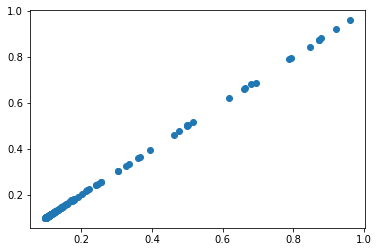

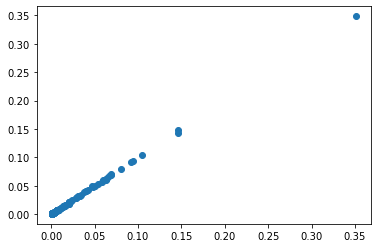

In [116]:
Nrep = 1000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train,)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test,)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

train_sigma.shape
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')
plt.show()


In [121]:
import time
from datetime import datetime
now = datetime.now()
import tensorflow.compat.v1 as tf

def function_train(it):
    import tensorflow.compat.v1 as tf
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 8e-3

    #optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False).minimize(cost)

    #optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    saver = tf.compat.v1.train.Saver(max_to_keep=10000)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 500

    for i in range(0,100):
        train_y = train_y_reps[:, i + it].reshape(N_train,1)
        test_y = test_y_reps[:, i + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.compat.v1.Session() as sess:
 
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 30000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma.reshape(N_train,1)
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma.reshape(N_test,1)})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            


            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = '25.08.2020'
            t_string = now.strftime("%H:%M:%S")
            print(d_string)
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s' % {'s': d_string, 'it': it, 'i': i})


            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 

            
            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        

        a = np.array(train_x[:,0]).reshape(N_train,)
        b = np.array(train_x[:,1]).reshape(N_train,)
        c = np.array(train_x[:,2]).reshape(N_train,)
        d = np.array(train_y).reshape(N_train,)
        e = np.array(predictions_values).reshape(N_train,)
        
        f = array_train
        g = array_test
       
        k = np.array(predict_x[:,0]).reshape(N_pred,)
        l = np.array(predict_x[:,1]).reshape(N_pred,)
        m = np.array(predict_x[:,2]).reshape(N_pred,)
        n = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(a,b,c,d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(f,g)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(k, l, m, n)),  delimiter=',', fmt='%f')
 

In [123]:
function_train(1)

processor1 starts training on 0416 and validating on 0104 samples
Epoch: 0001 | Training cost= 484838.531250000 | Validation cost= 447683.937500000
Epoch: 1001 | Training cost= 36.068458557 | Validation cost= 51.805294037
Epoch: 2001 | Training cost= 31.852952957 | Validation cost= 48.298179626
Epoch: 3001 | Training cost= 28.847614288 | Validation cost= 45.459812164
Epoch: 4001 | Training cost= 28.148511887 | Validation cost= 44.709323883
Epoch: 5001 | Training cost= 26.699035645 | Validation cost= 43.358100891
Epoch: 6001 | Training cost= 24.196603775 | Validation cost= 41.102046967
Epoch: 7001 | Training cost= 22.461883545 | Validation cost= 39.256187439
Epoch: 8001 | Training cost= 22.253507614 | Validation cost= 39.261634827
Epoch: 9001 | Training cost= 21.999176025 | Validation cost= 38.604988098
Epoch: 10001 | Training cost= 21.915365219 | Validation cost= 38.517070770
Epoch: 11001 | Training cost= 21.846950531 | Validation cost= 38.510105133
Epoch: 12001 | Training cost= 21.831

Epoch: 14001 | Training cost= 23.079557419 | Validation cost= 41.504543304
Epoch: 15001 | Training cost= 21.349437714 | Validation cost= 39.789089203
Epoch: 16001 | Training cost= 21.310085297 | Validation cost= 39.752407074
Epoch: 17001 | Training cost= 21.376871109 | Validation cost= 39.830520630
Epoch: 18001 | Training cost= 21.240365982 | Validation cost= 39.688533783
Epoch: 19001 | Training cost= 21.206613541 | Validation cost= 39.656574249
Epoch: 20001 | Training cost= 21.175296783 | Validation cost= 39.625694275
Epoch: 21001 | Training cost= 21.142883301 | Validation cost= 39.595375061
Epoch: 22001 | Training cost= 21.113170624 | Validation cost= 39.574836731
Epoch: 23001 | Training cost= 21.074466705 | Validation cost= 39.531997681
Epoch: 24001 | Training cost= 21.032653809 | Validation cost= 39.492458344
Epoch: 25001 | Training cost= 20.978567123 | Validation cost= 39.436820984
Epoch: 26001 | Training cost= 20.877046585 | Validation cost= 39.323799133
Epoch: 27001 | Training c

KeyboardInterrupt: 

## File with e_loss extrapolation

predict = []
time = [.1, 1]
for i, energy in enumerate([.6, 2]):
    
    for j in range(2):
        E_min = -.1
        E_max = .5
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


## File with beam energy extrapolation

predict = []
time = [.1, 1]
for i, energy in enumerate(np.linspace(0, 350, 36)):
    
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy/100
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


## File with time extrapolation

In [141]:
predict = []
energy = [.6, 2]

for i, time in enumerate(np.linspace(0, 200, 21)):
    
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time/100
        meanfile['energy'] = energy[j]
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


,x,time,energy
count,4.200000e+04,42000.000000,42000.000000
mean,-2.246880e-20,1.000000,1.300000
std,5.779348e-02,0.605537,0.700008
min,-1.000000e-01,0.000000,0.600000
25%,-5.000000e-02,0.500000,0.600000
50%,0.000000e+00,1.000000,1.300000
75%,5.000000e-02,1.500000,2.000000
max,1.000000e-01,2.000000,2.000000


In [142]:
prediction_file = pd.DataFrame()
prediction_file['x'] = predict_x['x']
prediction_file['time'] = predict_x['time']
prediction_file['energy'] = predict_x['energy']
good_files = np.loadtxt('good_files_vacuum')

In [143]:
d_string = '22.08.2020'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(0,500):
        
        if good_files[i] == 1:
            best_model = 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s'% {'s': d_string, 'it': 1, 'i': i}
            saver = tf.compat.v1.train.Saver(max_to_keep=1000)
            saver.restore(sess, best_model)
    
            extrapolation = sess.run(predictions,
                                feed_dict={
                                x: predict_x
                                })

            prediction_file['prediction_%(i)s' % {"i": i}] = extrapolation[:,0]
            

#plt.plot(predict_full['x'], predict_full['prediction'], colormap=predict_full['energy'], alpha=.8)   
prediction_file.to_csv('Data/Prediction_vacuum_time')

INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_2
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_3
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_4
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_5
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_7
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_8
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_9
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_10
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_11
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_12
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_13
INFO:tensorflow:Restoring parameters fr

INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_100
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_101
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_102
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_103
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_104
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_105
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_106
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_107
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_108
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_109
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_110
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_196
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_197
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_198
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_199
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_200
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_201
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_202
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_203
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_204
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_205
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_206
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_290
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_291
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_292
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_293
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_294
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_295
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_296
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_297
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_298
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_299
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_300
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_385
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_386
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_387
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_388
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_389
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_390
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_391
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_392
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_393
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_394
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_395
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_483
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_484
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_486
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_487
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_488
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_489
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_491
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_492
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_493
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_494
INFO:tensorflow:Restoring parameters from Models/Best_model/22.08.2020/x1_processor1_495
INFO:tensorflow:Resto

## Energy extrapolation plot

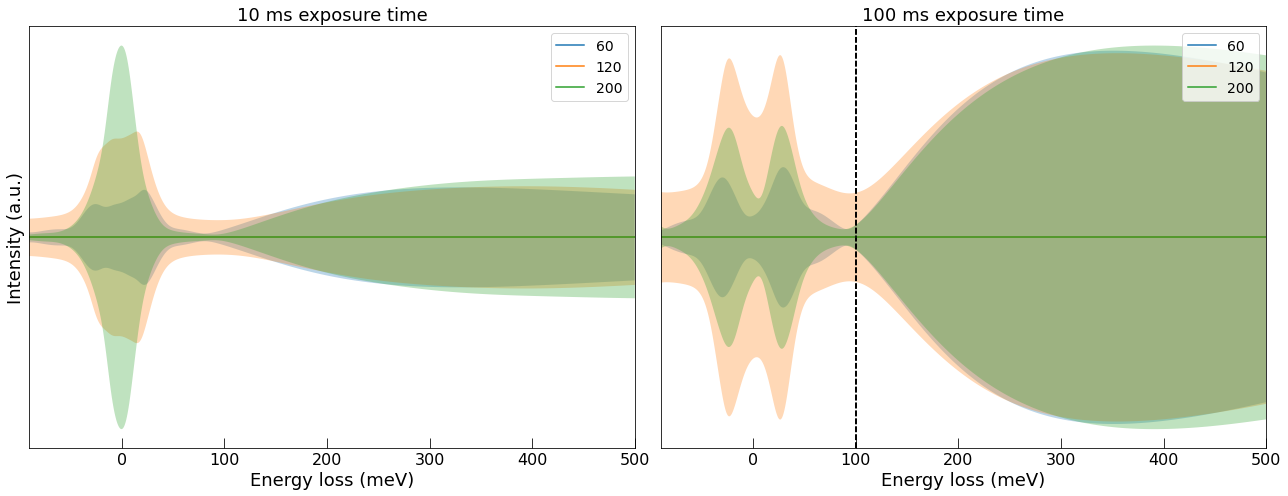

In [99]:
energy_file = pd.read_csv('paper_EELSML/sourceplots/data/Prediction_120keV')

groups = energy_file.groupby(['time', 'energy'])


ncols, nrows = 2,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)

plt.figure(figsize=(ncols*9,nrows*7))



for name, group in groups:
    mean_prediction = group.iloc[:, 4:].mean(axis=1).to_numpy()
    std_prediction = group.iloc[:, 4:].std(axis=1).to_numpy()
    
    
    if group['time'].max() == .1:
        i = 0
        ax = plt.subplot(gs[i])
        ax.set_title('10 ms exposure time', fontsize = 18)
        ax.set_ylabel('Intensity (a.u.)', fontsize = 18)
        #ax.set_ylim([0, 1])
        ax.plot(group.x*1000, np.divide(mean_prediction, mean_prediction), label=int(name[1] * 100))
        ax.fill_between(group.x*1000, np.divide(mean_prediction + std_prediction, mean_prediction), \
                        np.divide(mean_prediction - std_prediction, mean_prediction), alpha=.3)
    if group['time'].max() == 1:
        i = 1
        ax = plt.subplot(gs[i])
        #ax.set_ylim([0, 1.2])
        ax.set_title('100 ms exposure time', fontsize = 18)
        ax.plot(group.x*1000, np.divide(mean_prediction, mean_prediction), label=int(name[1] * 100))
        ax.fill_between(group.x*1000, np.divide(mean_prediction + std_prediction, mean_prediction), \
                        np.divide(mean_prediction - std_prediction, mean_prediction), alpha=.3)
        ax.axvline(x=100, color='black', linestyle='--')
    ax.set_xlim([-90, +500])
    ax.set_yticks([])
    #ax.set_xticks([-80, -40, 0, 40, 80])
    ax.set_xlabel('Energy loss (meV)', fontsize = 18)
   
    #ax.set_yticklabels(fontsize=1)
    ax.tick_params(which='major',direction='in',length=10, labelsize=16)
    ax.tick_params(which='minor',length=10, labelsize=14)

    ax.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig('120keV.pdf')


## E_beam extrapolation plot

In [137]:
ebeam_file = pd.read_csv('Data/Prediction_vacuum_Ebeam_350')

In [123]:
groups_time = ebeam_file.groupby(['time'])

for name, group in groups_time:
    groups_energy = group.groupby(['energy'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    fwhm_ups = []
    fwhm_downs = []
    
    for name_energy, group_energy in groups_energy:
        fwhm_array = []
        max_array = []
        
        
        for i in range(4,485):
            prediction = pd.DataFrame({"x": group_energy.x, "pred": group_energy.iloc[:,i]})
            max_x = prediction['x'][prediction['pred'] == prediction['pred'].max()].min()
            fwhm = prediction['x'][(prediction['x'] > 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] < prediction['pred'].max()/2)].min()
            maxvalue = prediction['pred'].max()
            max_array.append(maxvalue)
            fwhm_array.append(fwhm)
            
        # Remove nan values  
        fwhm_array = [x for x in fwhm_array if str(x) != 'nan']
        
        
        fwhm_mean = np.median(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_up = np.quantile(fwhm_array, 0.84)
        fwhm_down = np.quantile(fwhm_array, 0.16)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        fwhm_ups.append(fwhm_up)
        fwhm_downs.append(fwhm_down)
       
        fwhm_high = fwhm_ups
        fwhm_low = fwhm_downs
      
        np.savetxt('Data/Results/fwhmvalues350_mean_%(s)s' % {"s": name}, fwhm_means)
        np.savetxt('Data/Results/fwhmvalues350_std_%(s)s' % {"s": name}, fwhm_stds)
        np.savetxt('Data/Results/fwhmvalues350_up_%(s)s' % {"s": name}, fwhm_ups)
        np.savetxt('Data/Results/fwhmvalues350_down_%(s)s' % {"s": name}, fwhm_downs)

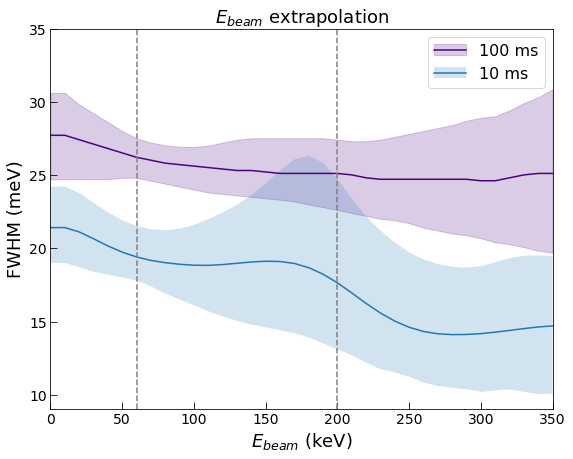

In [138]:
from matplotlib import rc
import matplotlib

fwhmvalues_mean_100 = np.loadtxt('Data/Results/fwhmvalues350_mean_1.0')
fwhmvalues_mean_10 = np.loadtxt('Data/Results/fwhmvalues350_mean_0.1')
up100 = np.loadtxt('Data/Results/fwhmvalues350_up_1.0')
up10 = np.loadtxt('Data/Results/fwhmvalues350_up_0.1')
low100 = np.loadtxt('Data/Results/fwhmvalues350_down_1.0')
low10 = np.loadtxt('Data/Results/fwhmvalues350_down_0.1')


hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
wl = 4

color2 = 'indigo'
plt.figure(figsize=(ncols*9,nrows*7))
ax = plt.subplot(gs[0])
ax.plot(np.linspace(0,350,36), smooth(fwhmvalues_mean_100 * 1000, wl), color = color2, label = '100 ms')
ax.fill_between(np.linspace(0,350,36), smooth(up100 * 1000, wl), smooth(low100 * 1000, wl), color = color2, alpha=.2, label = '100 ms')
ax.plot(np.linspace(0,350,36), smooth(fwhmvalues_mean_10 * 1000, wl*2), label = '10 ms')
ax.fill_between(np.linspace(0,350,36), smooth(up10 * 1000, wl*2), smooth(low10 * 1000, wl),  alpha=.2, label = '10 ms')
ax.axvline(x=60, linestyle='--', color='gray')
ax.axvline(x=200, linestyle='--', color='gray')
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8, labelsize=14)
ax.set_yticks([10, 15, 20, 25, 30, 35])
ax.set_ylabel('FWHM (meV)', fontsize = 18)
ax.set_xlim([0, 350])
ax.set_xlabel('$E_{beam}$ (keV)', fontsize = 18)
lables, handles = ax.get_legend_handles_labels() 
ax.legend([(lables[0], lables[2]), (lables[1], lables[3])], [(handles[0]), handles[1]], loc='upper right', fontsize=16)
ax.set_title('$E_{beam}$ extrapolation', fontsize=18)
plt.savefig('Ebeam_extrapolation_350.pdf')


## Time extrapolation plot

In [144]:
time_file = pd.read_csv('Data/Prediction_vacuum_time')

In [145]:
groups_energy = time_file.groupby(['energy'])

for name, group in groups_energy:
    groups_time = group.groupby(['time'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    fwhm_ups = []
    fwhm_downs = []
    
    for name_time, group_time in groups_time:
        fwhm_array = []
        max_array = []
        

        for i in range(4,480):
            prediction = pd.DataFrame({"x": group_time.x, "pred": group_time.iloc[:,i]})
            max_x = prediction['x'][prediction['pred'] == prediction['pred'].max()].min()
            fwhm = prediction['x'][(prediction['x'] > 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] < prediction['pred'].max()/2)].min()
            maxvalue = prediction['pred'].max()
            max_array.append(maxvalue)
            fwhm_array.append(fwhm)
            
        # Remove nan values  
        fwhm_array = [x for x in fwhm_array if str(x) != 'nan']
        
        
        fwhm_mean = np.median(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_up = np.quantile(fwhm_array, 0.84)
        fwhm_down = np.quantile(fwhm_array, 0.16)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        fwhm_ups.append(fwhm_up)
        fwhm_downs.append(fwhm_down)
      
        np.savetxt('Data/Results/fwhmvalues_time_mean_%(s)s' % {"s": name}, fwhm_means)
        np.savetxt('Data/Results/fwhmvalues_time_std_%(s)s' % {"s": name}, fwhm_stds)
        np.savetxt('Data/Results/fwhmvalues_time_up_%(s)s' % {"s": name}, fwhm_ups)
        np.savetxt('Data/Results/fwhmvalues_time_down_%(s)s' % {"s": name}, fwhm_downs)

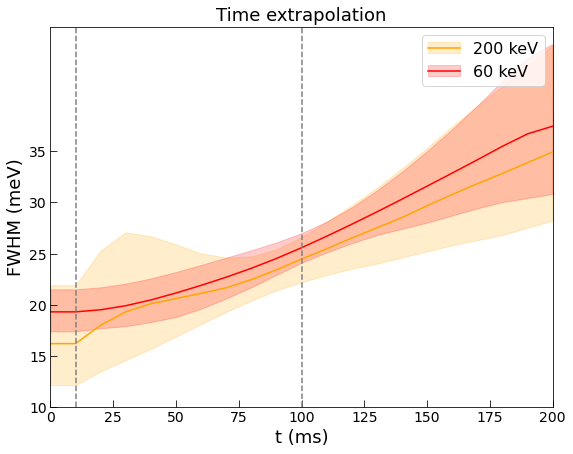

In [150]:
from matplotlib import rc
import matplotlib

fwhmvalues_mean_200 = np.loadtxt('Data/Results/fwhmvalues_time_mean_2.0')
fwhmvalues_mean_60 = np.loadtxt('Data/Results/fwhmvalues_time_mean_0.6')
up200 = np.loadtxt('Data/Results/fwhmvalues_time_up_2.0')
up60 = np.loadtxt('Data/Results/fwhmvalues_time_up_0.6')
low200 = np.loadtxt('Data/Results/fwhmvalues_time_down_2.0')
low60 = np.loadtxt('Data/Results/fwhmvalues_time_down_0.6')
fwhmvalues_std_200 = np.loadtxt('Data/Results/fwhmvalues_time_std_2.0')
fwhmvalues_std_60 = np.loadtxt('Data/Results/fwhmvalues_time_std_0.6')

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
wl = 4
color1 = 'red'
color2 = 'orange'
plt.figure(figsize=(ncols*9,nrows*7))
ax = plt.subplot(gs[0])
ax.plot(np.linspace(0,200,21), smooth(fwhmvalues_mean_200 * 1000, wl), color = color2, label = '200 keV')
ax.fill_between(np.linspace(0,200,21), smooth(up200 * 1000, wl), smooth(low200 * 1000, wl), color = color2, alpha=.2, label = '200 keV')
ax.plot(np.linspace(0,200,21), smooth(fwhmvalues_mean_60 * 1000, wl*2), color=color1, label = '60 keV')
ax.fill_between(np.linspace(0,200,21), smooth(up60 * 1000, wl*2), smooth(low60 * 1000, wl), color=color1, alpha=.2, label = '60 keV')
ax.axvline(x=10, linestyle='--', color='gray')
ax.axvline(x=100, linestyle='--', color='gray')
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8, labelsize=14)
ax.set_yticks([10, 15, 20, 25, 30, 35])
ax.set_ylabel('FWHM (meV)', fontsize = 18)
ax.set_xlim([0, 200])
ax.set_xlabel('t (ms)', fontsize = 18)
lables, handles = ax.get_legend_handles_labels() 
ax.legend([(lables[0], lables[2]), (lables[1], lables[3])], [(handles[0]), handles[1]], loc='upper right', fontsize=16)
ax.set_title('Time extrapolation', fontsize=18)
plt.savefig('Time_extrapolation_350.pdf')


## Residuals

## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)